In [ ]:
!pip install sympy numpy matplotlib;

---
##### Title: Gradient Descent Updates on Two Functions
##### Author: Ujjayant Kadian
##### Date: 2025-02-27
---

## Introduction
In this notebook, we will implement four gradient-based optimization algorithms:
1. Polyak Step Size
2. RMSProp
3. Heavy Ball
4. Adam

We will apply these algorithms to the following two functions:

1) f1(x, y) = 7*(x-1)^4 + 3*(y-9)^2
2) f2(x, y) = max(x-1, 0) + 3 * |y-9|

We will use sympy to compute symbolic gradients for the differentiable parts, and we will carefully handle the non-differentiable points in the second function via the Heaviside function and absolute value derivatives. 

We will then explore the effect of changing parameters (e.g., alpha, beta, gamma) and discuss the convergence behavior and sensitivity of each method.

---

In [1]:
import sympy
import numpy as np
import matplotlib.pyplot as plt

---
## Theoretical Background

### 1. Gradient Descent
Gradient descent updates a parameter vector $\theta$ by moving it in the direction opposite to the gradient of the function $f(\theta)$. A basic update rule is:

$$
\theta_{n+1} = \theta_n - \alpha \nabla f(\theta_n)
$$

where $\alpha$ is the step size (learning rate).

### 2. Polyak Step Size
Polyak step size uses knowledge of $f(\theta) - f^*$ to adapt the step size. The update is:

$$
\theta_{n+1} = \theta_n - \alpha_n \nabla f(\theta_n)
$$

where 

$$
\alpha_n = \frac{f(\theta_n) - f^*}{||\nabla f(\theta_n)||^2}
$$

and $f^*$ is an estimate of the minimum function value (often set to 0 if unknown, or some known lower bound).

### 3. RMSProp
RMSProp maintains a moving average of the squared gradients to normalize the parameter updates:

$$
E[g^2]_n = \beta E[g^2]_{n-1} + (1 - \beta) g_n^2
$$

$$
\theta_{n+1} = \theta_n - \frac{\alpha}{\sqrt{E[g^2]_n + \epsilon}} g_n
$$

where $\beta$ is a decay parameter $(0 < \beta < 1)$ and $\epsilon$ is a small constant for numerical stability.

### 4. Heavy Ball
Heavy Ball method (Polyak's momentum) incorporates a momentum term to accelerate convergence:

$$
v_{n+1} = \beta v_n + \alpha \nabla f(\theta_n)
$$

$$
\theta_{n+1} = \theta_n - v_{n+1}
$$

where $0 < \beta < 1$ is the momentum parameter and $\alpha$ is the learning rate.

### 5. Adam
Adam (Adaptive Moment Estimation) keeps track of both the first moment (mean) and the second moment (uncentered variance) of the gradients:

$$
m_{n+1} = \beta_1 m_n + (1 - \beta_1) g_n
$$

$$
v_{n+1} = \beta_2 v_n + (1 - \beta_2) g_n^2
$$

$$
\hat{m} = \frac{m_{n+1}}{1 - \beta_1^n}
$$

$$
\hat{v} = \frac{v_{n+1}}{1 - \beta_2^n}
$$

$$
\theta_{n+1} = \theta_n - \alpha \frac{\hat{m}}{\sqrt{\hat{v}} + \epsilon}
$$
 
Typically, $\beta_1 \approx 0.9, \beta_2 \approx 0.999, \epsilon \approx 10^{-8}$.
 
---

## Implementation
We will now implement each of these methods as functions in Python.
### 1. Symbolic Derivatives with sympy
First, let's define the two functions and their gradients in sympy. We will handle the piecewise nature of max(x-1,0) and absolute value with the Heaviside function.

---

In [2]:
x, y = sympy.symbols('x y', real=True)

# Function 1: f1(x, y) = 7*(x-1)**4 + 3*(y-9)**2
f1 = 7*(x - 1)**4 + 3*(y - 9)**2

# Symbolic gradient of f1
grad_f1 = [sympy.diff(f1, x), sympy.diff(f1, y)]

# Function 2: f2(x, y) = max(x-1, 0) + 3*|y-9|
# max(x-1, 0) can be expressed as (x-1)*(Heaviside(x-1))
# absolute value of (y-9) can be expressed as (y-9)*sign(y-9)
# For the Heaviside step function, sympy uses Heaviside(x).
# For absolute value, sympy has Abs(y-9).
H = sympy.Heaviside
f2 = (x - 1)*H(x - 1) + 3*sympy.Abs(y - 9)

grad_f2 = [sympy.diff(f2, x), sympy.diff(f2, y)]

print("f1:", f1)
print("grad_f1:", grad_f1)
print("f2:", f2)
print("grad_f2:", grad_f2)


f1: 7*(x - 1)**4 + 3*(y - 9)**2
grad_f1: [28*(x - 1)**3, 6*y - 54]
f2: (x - 1)*Heaviside(x - 1) + 3*Abs(y - 9)
grad_f2: [(x - 1)*DiracDelta(x - 1) + Heaviside(x - 1), 3*sign(y - 9)]


---
Note: The derivative of $(x-1)*Heaviside(x-1)$ w.r.t $x$ is:  
 $Heaviside(x-1) + (x-1)*DiracDelta(x-1)$   
but ignoring the delta term for $x != 1$, we effectively get $Heaviside(x-1)$.  
Similarly, derivative of $3*Abs(y-9)$ w.r.t y is $3*sign(y-9)$, except at $y=9$.  

---

In [3]:
f1_func = sympy.lambdify((x, y), f1, 'numpy')
grad_f1_func = [
    sympy.lambdify((x, y), grad_f1[0], 'numpy'),
    sympy.lambdify((x, y), grad_f1[1], 'numpy')
]

f2_func = sympy.lambdify((x, y), f2, 'numpy')
grad_f2_func = [
    sympy.lambdify((x, y), grad_f2[0], 'numpy'),
    sympy.lambdify((x, y), grad_f2[1], 'numpy')
]

In [4]:
# Function to return the gradient of f1 at a given point = (x, y).
def gradient_f1(point):
    x_val, y_val = point
    return np.array([grad_f1_func[0](x_val, y_val),
                     grad_f1_func[1](x_val, y_val)], dtype=float)

# Similarly, a function to return the gradient of f2 at the given point = (x, y). 
# Note that at the non-differentiable points, the Heaviside/Sign function has a jump. If we use sympy, 
# Numpy would not be able to handle DiracDelta function. Thus defining the gradient manually.

def gradient_f2(point):
    x_val, y_val = point
    # Gradient with respect to x for max(x-1, 0)
    if x_val > 1:
        grad_x = 1.0
    elif x_val < 1:
        grad_x = 0.0
    else:  # x_val == 1, choosing a subgradient (commonly 0.5)
        grad_x = 0.5

    # Gradient with respect to y for 3*|y-9|
    if y_val > 9:
        grad_y = 3.0
    elif y_val < 9:
        grad_y = -3.0
    else:  # y_val == 9, choosing subgradient 0
        grad_y = 0.0

    return np.array([grad_x, grad_y], dtype=float)

def f1_val(point):
    return f1_func(point[0], point[1])

def f2_val(point):
    return f2_func(point[0], point[1])


---
### 2. Optimization Algorithms
---

In [5]:
def polyak_update(point, grad, func_val, f_star_est=0.0):
    grad_norm_sq = np.sum(grad**2)
    if grad_norm_sq < 1e-12:
        # Avoid division by zero if gradient is extremely small
        return point
    alpha_n = (func_val - f_star_est) / grad_norm_sq
    return point - alpha_n * grad

def rmsprop_update(point, grad, cache, alpha=0.01, beta=0.9, eps=1e-8):
    new_cache = beta*cache + (1-beta)*(grad**2)
    step = alpha * grad / (np.sqrt(new_cache + eps))
    new_point = point - step
    return new_point, new_cache, np.linalg.norm(step)

def heavy_ball_update(point, grad, velocity, alpha=0.01, beta=0.9):
    new_velocity = beta*velocity + alpha*grad
    step = new_velocity  # the actual vector subtracted from point
    new_point = point - step
    return new_point, new_velocity, np.linalg.norm(step)

def adam_update(point, grad, m, v, t, alpha=0.01, beta1=0.9, beta2=0.999, eps=1e-8):
    new_m = beta1*m + (1-beta1)*grad
    new_v = beta2*v + (1-beta2)*(grad**2)
    # bias corrections
    m_hat = new_m / (1 - beta1**t)
    v_hat = new_v / (1 - beta2**t)
    step = alpha * m_hat / (np.sqrt(v_hat) + eps)
    new_point = point - step
    return new_point, new_m, new_v, np.linalg.norm(step)


---
## 3. Experiments
We will now run each algorithm on both f1 and f2, exploring the effect of parameters.

---

In [6]:
def run_polyak(func, grad_func, init_point, f_star_values, max_iter=200, tol=1e-6):
    results = {}
    for f_star in f_star_values:
        history = []
        point = np.array(init_point, dtype=float)
        for it in range(1, max_iter+1):
            val = func(point)
            grad = grad_func(point)
            history.append((it, val, point.copy()))
            if np.linalg.norm(grad) < tol:
                break
            grad_norm_sq = np.sum(grad**2)
            if grad_norm_sq < 1e-12:
                break
            # Polyak step size
            alpha_n = (val - f_star) / grad_norm_sq
            point = point - alpha_n * grad
        results[f_star] = history
    return results
    
def run_rmsprop(func, grad_func, init_point, 
                alpha_values, beta_values, 
                max_iter=200, tol=1e-8):
    results = {}
    for alpha in alpha_values:
        for beta in beta_values:
            history = []
            point = np.array(init_point, dtype=float)
            cache = np.zeros_like(point)
            for it in range(1, max_iter+1):
                val = func(point)
                g = grad_func(point)
                point, cache, step_norm = rmsprop_update(point, g, cache,
                                                         alpha=alpha, beta=beta)
                history.append((it, val, point.copy(), step_norm))
                if step_norm < tol:
                    break
            # store under (alpha, beta)
            results[(alpha, beta)] = history
    return results

def run_heavy_ball(func, grad_func, init_point,
                   alpha_values, beta_values,
                   max_iter=200, tol=1e-8):
    results = {}
    for alpha in alpha_values:
        for beta in beta_values:
            history = []
            point = np.array(init_point, dtype=float)
            velocity = np.zeros_like(point)
            for it in range(1, max_iter+1):
                val = func(point)
                g = grad_func(point)
                point, velocity, step_norm = heavy_ball_update(point, g, velocity,
                                                               alpha=alpha, beta=beta)
                history.append((it, val, point.copy(), step_norm))
                if step_norm < tol:
                    break
            results[(alpha, beta)] = history
    return results

def run_adam(func, grad_func, init_point,
             alpha_values, beta1_values, beta2_values,
             max_iter=200, tol=1e-8):
    results = {}
    for alpha in alpha_values:
        for b1 in beta1_values:
            for b2 in beta2_values:
                history = []
                point = np.array(init_point, dtype=float)
                m = np.zeros_like(point)
                v = np.zeros_like(point)
                for it in range(1, max_iter+1):
                    val = func(point)
                    g = grad_func(point)
                    point, m, v, step_norm = adam_update(point, g, m, v, it,
                                                         alpha=alpha, beta1=b1, beta2=b2)
                    history.append((it, val, point.copy(), step_norm))
                    if step_norm < tol:
                        break
                results[(alpha, b1, b2)] = history
    return results

---
#### Parameter Grids
Let's pick a wide range of alpha values: from 0.001 up to 0.3.  
We'll pick beta values for RMSProp, Heavy Ball in [0.25, 0.9].  
For Adam, we'll pick alpha from [0.001, 0.01, 0.1], beta1 from [0.25, 0.9],
and beta2 from [0.5, 0.99] just to illustrate a range.  

---

In [7]:
f_star_vals = [0, -1, 1]

alpha_vals_rmsprop = [0.001, 0.01, 0.1, 0.3]
beta_vals_rmsprop = [0.25, 0.9]

alpha_vals_hb = [0.001, 0.002, 0.0025]
beta_vals_hb = [0.25, 0.9]

alpha_vals_adam = [0.001, 0.01, 0.1]
beta1_vals_adam = [0.25, 0.9]
beta2_vals_adam = [0.5, 0.99]


# Choose initial points
init_point_f1 = [5.0, 0.0]   # somewhat far from (1,9)
init_point_f2 = [0.0, 0.0]   # also somewhat far from (1,9)

polyak_results_f1 = run_polyak(f1_val, gradient_f1, init_point_f1, f_star_vals, max_iter=200)
polyak_results_f2 = run_polyak(f2_val, gradient_f2, init_point_f2, f_star_vals, max_iter=200)

rmsprop_results_f1 = run_rmsprop(f1_val, gradient_f1, init_point_f1,
                                 alpha_vals_rmsprop, beta_vals_rmsprop,
                                 max_iter=200)

rmsprop_results_f2 = run_rmsprop(f2_val, gradient_f2, init_point_f2,
                                 alpha_vals_rmsprop, beta_vals_rmsprop,
                                 max_iter=200)

hb_results_f1 = run_heavy_ball(f1_val, gradient_f1, init_point_f1,
                               alpha_vals_hb, beta_vals_hb, max_iter=200)

hb_results_f2 = run_heavy_ball(f2_val, gradient_f2, init_point_f2,
                               alpha_vals_hb, beta_vals_hb, max_iter=200)

adam_results_f1 = run_adam(f1_val, gradient_f1, init_point_f1,
                           alpha_vals_adam, beta1_vals_adam, beta2_vals_adam,
                           max_iter=200)

adam_results_f2 = run_adam(f2_val, gradient_f2, init_point_f2,
                           alpha_vals_adam, beta1_vals_adam, beta2_vals_adam,
                           max_iter=200)


---
#### Plot: Function-Value vs Iteration

---

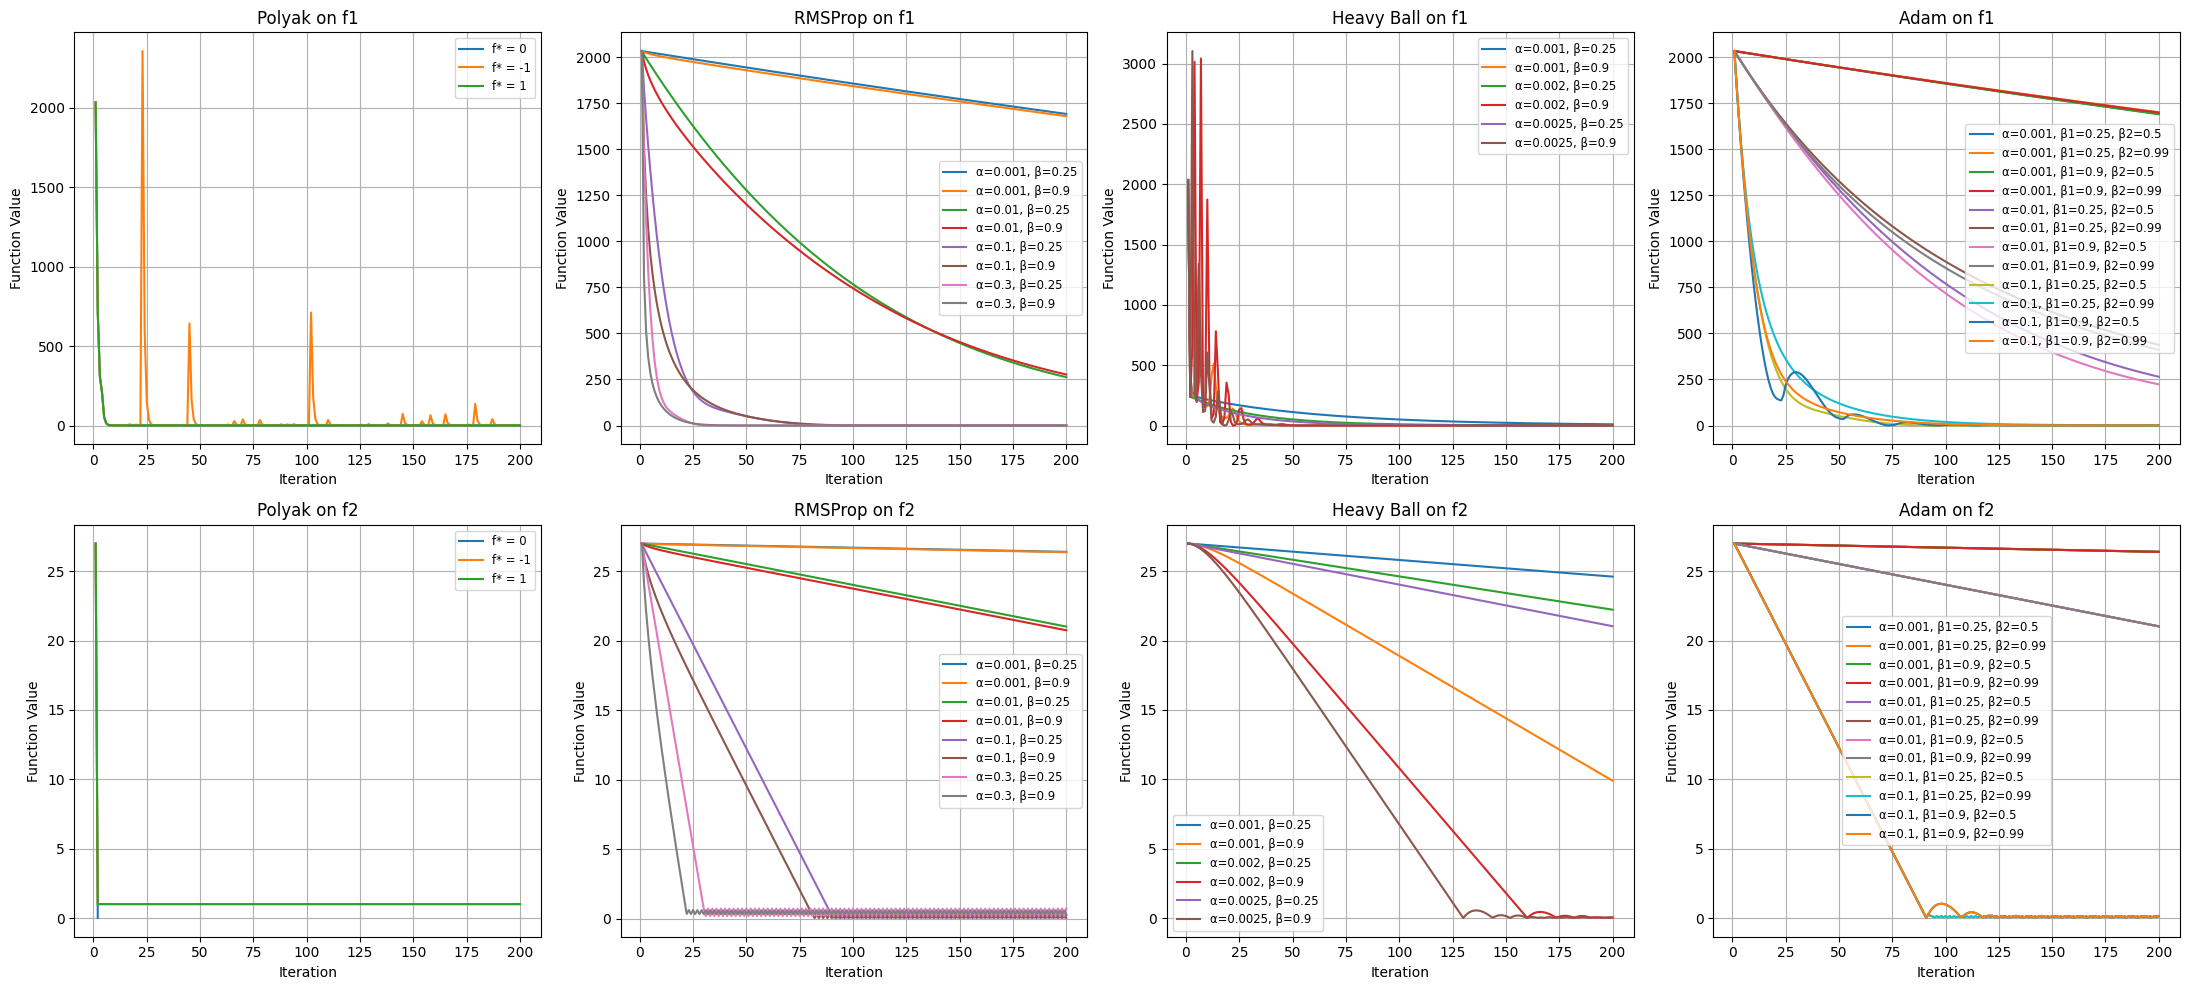

In [8]:
fig, axs = plt.subplots(2, 4, figsize=(22, 10))

# Polyak on f1
for f_star, history in polyak_results_f1.items():
    iters = [h[0] for h in history]
    vals = [h[1] for h in history]
    axs[0, 0].plot(iters, vals, label=f"f* = {f_star}")
axs[0, 0].set_title("Polyak on f1")
axs[0, 0].set_xlabel("Iteration")
axs[0, 0].set_ylabel("Function Value")
axs[0, 0].grid(True)
axs[0, 0].legend(fontsize='small')

# RMSProp on f1
for (alpha, beta), history in rmsprop_results_f1.items():
    iters = [h[0] for h in history]
    vals = [h[1] for h in history]
    axs[0, 1].plot(iters, vals, label=f"α={alpha}, β={beta}")
axs[0, 1].set_title("RMSProp on f1")
axs[0, 1].set_xlabel("Iteration")
axs[0, 1].set_ylabel("Function Value")
axs[0, 1].grid(True)
axs[0, 1].legend(fontsize='small')

# Heavy Ball on f1
for (alpha, beta), history in hb_results_f1.items():
    iters = [h[0] for h in history]
    vals = [h[1] for h in history]
    axs[0, 2].plot(iters, vals, label=f"α={alpha}, β={beta}")
axs[0, 2].set_title("Heavy Ball on f1")
axs[0, 2].set_xlabel("Iteration")
axs[0, 2].set_ylabel("Function Value")
axs[0, 2].grid(True)
axs[0, 2].legend(fontsize='small')

# Adam on f1
for (alpha, b1, b2), history in adam_results_f1.items():
    iters = [h[0] for h in history]
    vals = [h[1] for h in history]
    axs[0, 3].plot(iters, vals, label=f"α={alpha}, β1={b1}, β2={b2}")
axs[0, 3].set_title("Adam on f1")
axs[0, 3].set_xlabel("Iteration")
axs[0, 3].set_ylabel("Function Value")
axs[0, 3].grid(True)
axs[0, 3].legend(fontsize='small')

# Polyak on f2
for f_star, history in polyak_results_f2.items():
    iters = [h[0] for h in history]
    vals = [h[1] for h in history]
    axs[1, 0].plot(iters, vals, label=f"f* = {f_star}")
axs[1, 0].set_title("Polyak on f2")
axs[1, 0].set_xlabel("Iteration")
axs[1, 0].set_ylabel("Function Value")
axs[1, 0].grid(True)
axs[1, 0].legend(fontsize='small')

# RMSProp on f2
for (alpha, beta), history in rmsprop_results_f2.items():
    iters = [h[0] for h in history]
    vals = [h[1] for h in history]
    axs[1, 1].plot(iters, vals, label=f"α={alpha}, β={beta}")
axs[1, 1].set_title("RMSProp on f2")
axs[1, 1].set_xlabel("Iteration")
axs[1, 1].set_ylabel("Function Value")
axs[1, 1].grid(True)
axs[1, 1].legend(fontsize='small')

# Heavy Ball on f2
for (alpha, beta), history in hb_results_f2.items():
    iters = [h[0] for h in history]
    vals = [h[1] for h in history]
    axs[1, 2].plot(iters, vals, label=f"α={alpha}, β={beta}")
axs[1, 2].set_title("Heavy Ball on f2")
axs[1, 2].set_xlabel("Iteration")
axs[1, 2].set_ylabel("Function Value")
axs[1, 2].grid(True)
axs[1, 2].legend(fontsize='small')

# Adam on f2
for (alpha, b1, b2), history in adam_results_f2.items():
    iters = [h[0] for h in history]
    vals = [h[1] for h in history]
    axs[1, 3].plot(iters, vals, label=f"α={alpha}, β1={b1}, β2={b2}")
axs[1, 3].set_title("Adam on f2")
axs[1, 3].set_xlabel("Iteration")
axs[1, 3].set_ylabel("Function Value")
axs[1, 3].grid(True)
axs[1, 3].legend(fontsize='small')

plt.tight_layout()
plt.show()


---
#### Plot: Step Size vs Iteration

---

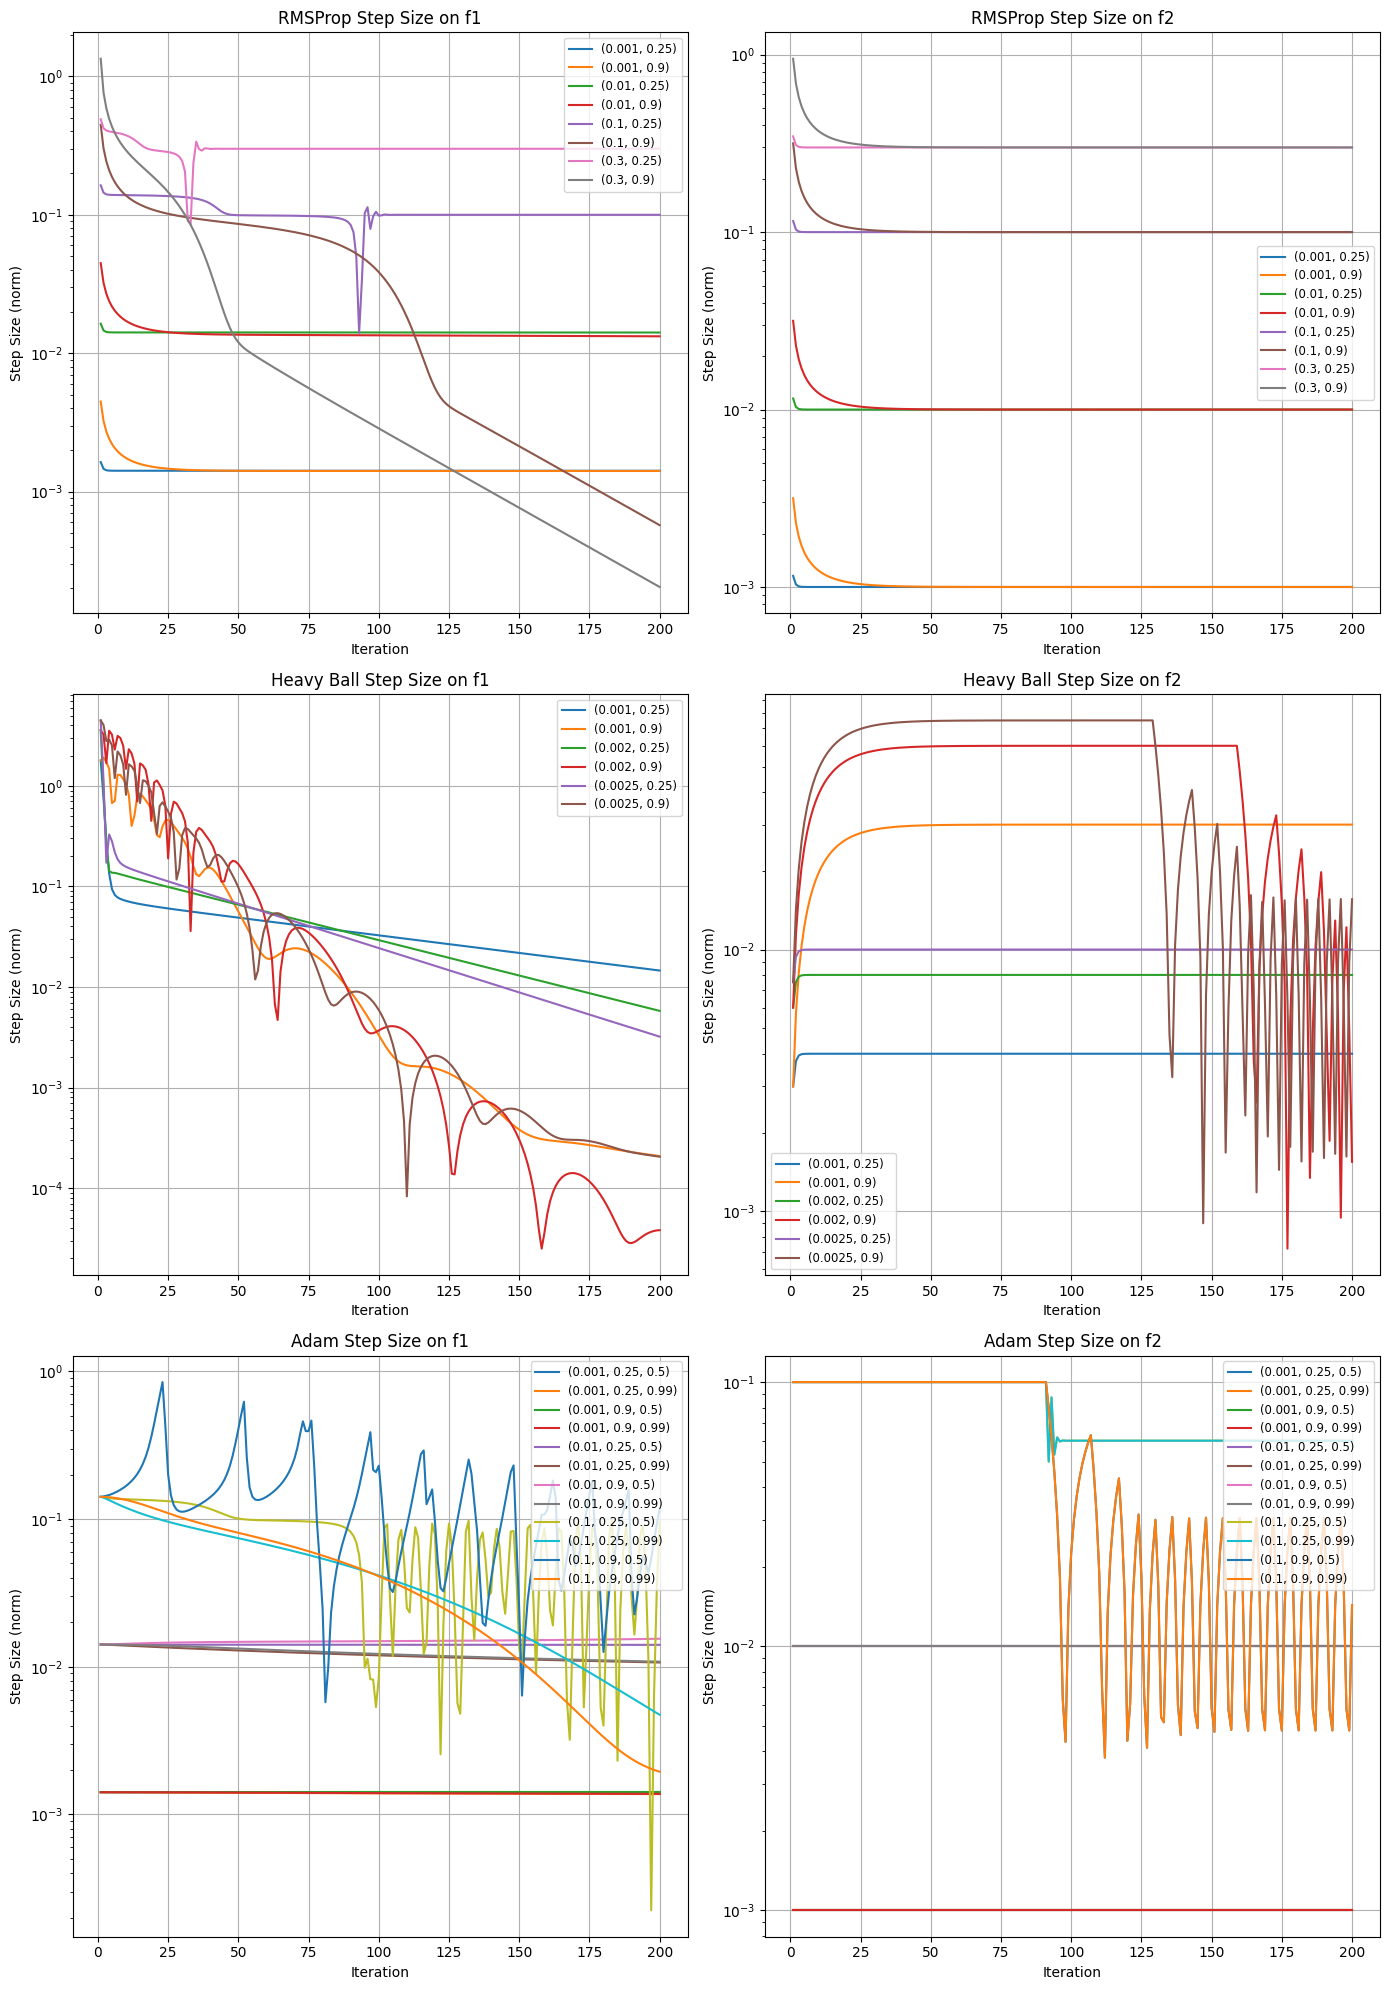

In [9]:
def plot_step_size_results(results_dict, ax, title_prefix='Step Size'):
    for key, history in results_dict.items():
        iters = [h[0] for h in history]
        step_sizes = [h[3] for h in history]
        label_str = str(key)
        ax.plot(iters, step_sizes, label=label_str)
    ax.set_title(title_prefix)
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Step Size (norm)")
    ax.set_yscale('log')
    ax.legend(fontsize='small')
    ax.grid(True)

fig, axs = plt.subplots(3, 2, figsize=(14, 20))
# For f1 (left column)
plot_step_size_results(rmsprop_results_f1, axs[0,0], "RMSProp Step Size on f1")
plot_step_size_results(hb_results_f1, axs[1,0], "Heavy Ball Step Size on f1")
plot_step_size_results(adam_results_f1, axs[2,0], "Adam Step Size on f1")
# For f2 (right column)
plot_step_size_results(rmsprop_results_f2, axs[0,1], "RMSProp Step Size on f2")
plot_step_size_results(hb_results_f2, axs[1,1], "Heavy Ball Step Size on f2")
plot_step_size_results(adam_results_f2, axs[2,1], "Adam Step Size on f2")


plt.tight_layout()
plt.show()

---
#### Plot: Contour Plot

---

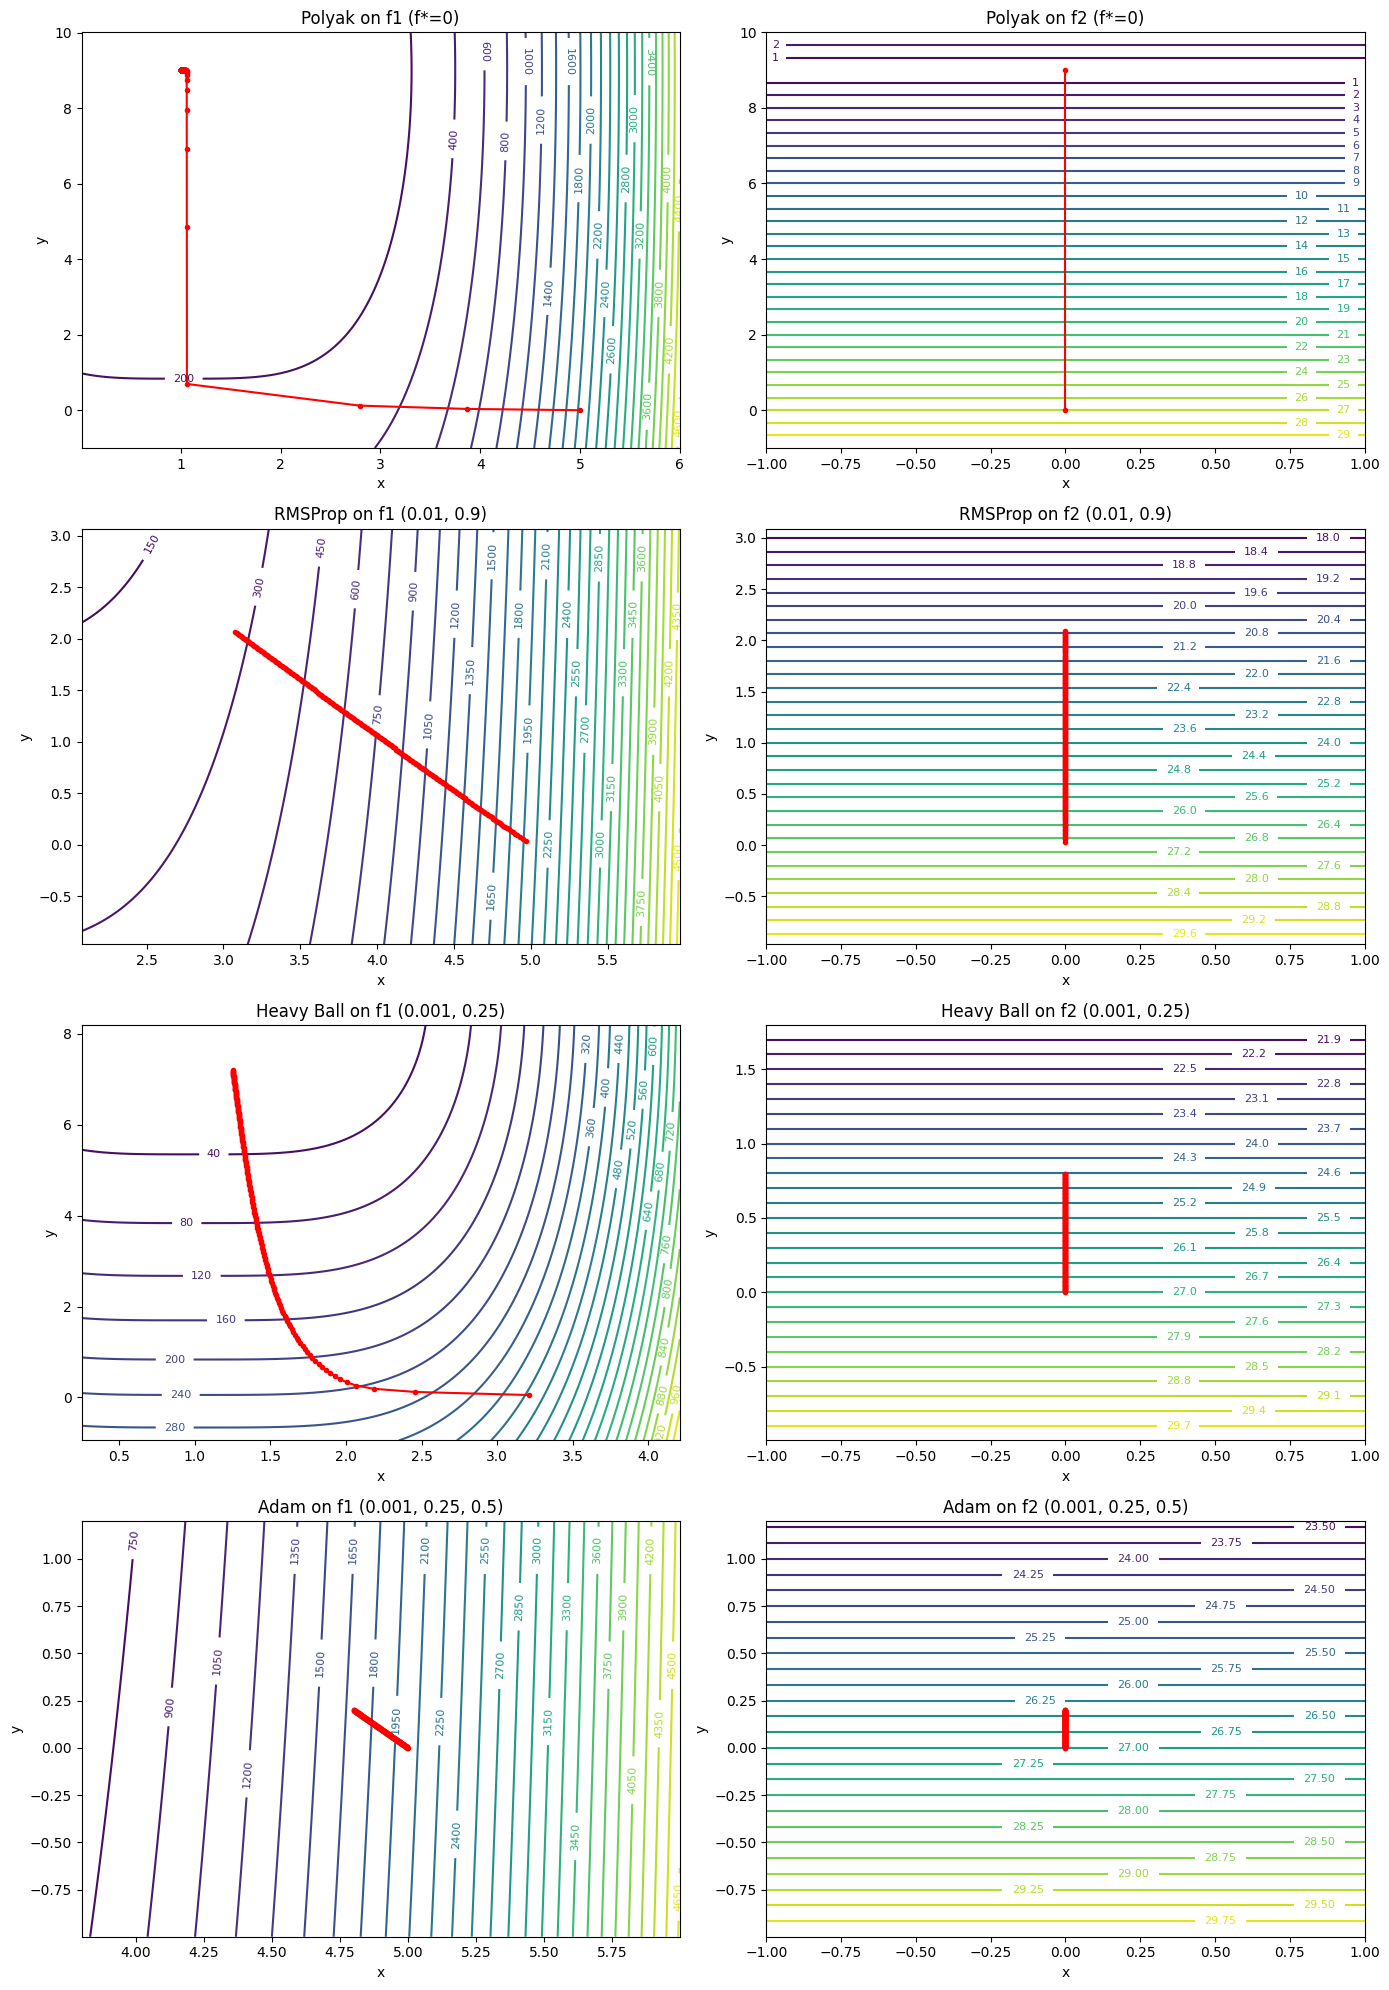

In [10]:
def contour_plot_with_path(func, history, title='Contour Plot', levels=30, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,6))
    points = np.array([h[2] for h in history])
    # Determine region with margin
    x_min, x_max = points[:,0].min()-1, points[:,0].max()+1
    y_min, y_max = points[:,1].min()-1, points[:,1].max()+1
    xs = np.linspace(x_min, x_max, 200)
    ys = np.linspace(y_min, y_max, 200)
    X, Y = np.meshgrid(xs, ys)
    Z = np.zeros_like(X)
    # Evaluate func on grid
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i,j] = func([X[i,j], Y[i,j]])
    cs = ax.contour(X, Y, Z, levels=levels, cmap='viridis')
    ax.clabel(cs, inline=1, fontsize=8)
    ax.plot(points[:,0], points[:,1], 'ro-', markersize=3)
    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")


# For each method, choose a representative parameter key (if available)
# For RMSProp, Heavy Ball, Adam, choose (0.01, 0.9) or (0.01, 0.9, 0.999) if available.
polyak_key = 0 if 0 in polyak_results_f1 else list(polyak_results_f1.keys())[0]
rmsprop_key = (0.01, 0.9) if (0.01, 0.9) in rmsprop_results_f1 else list(rmsprop_results_f1.keys())[0]
hb_key = (0.01, 0.9) if (0.01, 0.9) in hb_results_f1 else list(hb_results_f1.keys())[0]
adam_key = (0.01, 0.9, 0.999) if (0.01, 0.9, 0.999) in adam_results_f1 else list(adam_results_f1.keys())[0]

fig, axs = plt.subplots(4, 2, figsize=(14, 20))

# Polyak
history_polyak_f1 = polyak_results_f1[polyak_key]
contour_plot_with_path(f1_val, history_polyak_f1, title=f"Polyak on f1 (f*={polyak_key})", ax=axs[0,0])
history_polyak_f2 = polyak_results_f2[polyak_key]  # use same f* value
contour_plot_with_path(f2_val, history_polyak_f2, title=f"Polyak on f2 (f*={polyak_key})", ax=axs[0,1])

# RMSProp
history_rmsprop_f1 = rmsprop_results_f1[rmsprop_key]
contour_plot_with_path(f1_val, history_rmsprop_f1, title=f"RMSProp on f1 {rmsprop_key}", ax=axs[1,0])
history_rmsprop_f2 = rmsprop_results_f2[rmsprop_key]
contour_plot_with_path(f2_val, history_rmsprop_f2, title=f"RMSProp on f2 {rmsprop_key}", ax=axs[1,1])

# Heavy Ball
history_hb_f1 = hb_results_f1[hb_key]
contour_plot_with_path(f1_val, history_hb_f1, title=f"Heavy Ball on f1 {hb_key}", ax=axs[2,0])
history_hb_f2 = hb_results_f2[hb_key]
contour_plot_with_path(f2_val, history_hb_f2, title=f"Heavy Ball on f2 {hb_key}", ax=axs[2,1])

# Adam
history_adam_f1 = adam_results_f1[adam_key]
contour_plot_with_path(f1_val, history_adam_f1, title=f"Adam on f1 {adam_key}", ax=axs[3,0])
history_adam_f2 = adam_results_f2[adam_key]
contour_plot_with_path(f2_val, history_adam_f2, title=f"Adam on f2 {adam_key}", ax=axs[3,1])

plt.tight_layout()
plt.show()

---
### 4. Observations from the Optimization Plots

Below are a few key observations regarding each method (Polyak, RMSProp, Heavy Ball, and Adam) applied to the two functions $f_1(x,y)$ and $f_2(x,y)$. We focus on how varying parameters ($\alpha$, $\beta$, etc.) impact the convergence behavior, step size, and iteration paths.

---

#### 1. Polyak Method

1. **Effect of $f^*$ Estimate**  
   - When $f^*$ is close to the true minimum value (in this case, $0$ for both $f_1$ and $f_2$), Polyak converges more smoothly and quickly.  
   - A mismatched $f^*$ (e.g., $-1$ or $+1$) can lead to overshooting or slower convergence. This is visible in the function-value-vs-iteration plots, where curves with an incorrect $f^*$ either converge more slowly or oscillate before settling.

2. **Behavior on $f_2$ (Non-differentiable Corners)**  
   - Because $f_2$ has corners at $(x=1)$ and $(y=9)$, the subgradient can suddenly change.  
   - If $f^*$ is significantly off, the step size may be too large, causing the iterates to jump around the corner region or take longer to settle on the subgradient path.

3. **Contour Plots**  
   - In the contour plots for $f_1$, we see the path heading toward $(1,9)$.  
   - For $f_2$, the path can “snap” to lines where the gradient is constant, reflecting how Polyak steps handle piecewise linear functions.

---

#### 2. RMSProp

1. **Effect of $\alpha$ (Learning Rate)**  
   - **Large $\alpha$** (e.g., $0.3$) can cause faster initial descent but may overshoot or even diverge, especially for smaller $\beta$.  
   - **Smaller $\alpha$** (e.g., $0.001$) yields more stable but slower convergence. In the plots, you can see that the function value decreases more gently.

2. **Effect of $\beta$**  
   - $\beta$ controls the moving average of the squared gradients.  
   - **$\beta=0.25$** provides stronger smoothing, leading to steadier step sizes and fewer oscillations.  
   - **$\beta=0.9$** is more reactive to recent gradients, so the step size can fluctuate more, as seen in the step-size-vs-iteration plots (some curves jump around more).

3. **Behavior on $f_2$**  
   - The piecewise nature of $f_2$ causes plateaus in the step sizes, with lower $\alpha$ plateauing fast.
   - The contour plot also displays the "snap" of the path.

4. **Contour Plot**: The path seems to be converging very slowky for $f_1$ and getting snapped for $f_2$.

---

#### 3. Heavy Ball (Momentum)

1. **Effect of $\alpha$**  
   - **Too large** $\alpha$ (e.g., $0.3$) can cause big oscillations or outright divergence, especially combined with high momentum ($\beta=0.9$) as seen in the graphs.  
   - **Smaller** $\alpha$ is more stable but may converge slowly.

2. **Effect of $\beta$** (Momentum)  
   - **High momentum** ($\beta=0.9$) can accelerate initial convergence but risks overshooting near the minimum, as the velocity term keeps pushing the iterate. You can see “spiky” or oscillatory curves in the function-value plots or step-size plots.  
   - **Lower momentum** ($\beta=0.25$) is more damped, so the function value tends to decrease more smoothly, albeit at a slower rate.

3. **Step-Size Plots**  
   - The “step size” here corresponds to $\|\beta \cdot v + \alpha \cdot \nabla f\|$. With high momentum, you often see a larger update initially and then some oscillations before settling. The plots show that for smaller $\alpha$, the step size diminishes steadily.

4. **Contour Plots**
   -  $f_1$ path seems to be converging with the selection of $\alpha=0.001, \beta=0.25$, but getting snapped for $f_2$.

---

#### 4. Adam

1. **Effect of $\alpha$**  
   - Similar to RMSProp, a larger $\alpha$ can speed up initial descent but risks instability, especially if $\beta_1$ or $\beta_2$ are not tuned.  
   - A moderate $\alpha$ (e.g., $0.01$) often provides a good balance of speed and stability.

2. **Effect of $\beta_1$ and $\beta_2$**  
   - $\beta_1$ controls how quickly the first moment (mean of gradients) adapts; $\beta_2$ controls the second moment (variance).  
   - **Lower $\beta_1$** (e.g., $0.25$) makes the estimate more “reactive” to recent gradients but can lead to noisier updates.  
   - **Lower $\beta_2$** (e.g., $0.5$) means the variance estimate is also more reactive, causing more fluctuations in the step size.  
   - **Higher $\beta_2$** (e.g., $0.99$) smooths the second moment, often resulting in a more stable, steadily shrinking step size.

3. **Step-Size Plots**  
   - Adam’s step size typically decreases smoothly, thanks to the adaptive scaling. You can see that with high $\beta_1, \beta_2$, the step size drops steadily over iterations.

4. **Behavior on $f_2$**  
   - Adam generally handles the corner better than pure momentum methods if $\alpha$ is not too large. However, you still might see some oscillation if the subgradient changes abruptly and $\alpha$ or momentum are high.

5. **Contour Plots** show a very slow path, and for $f_2$, its trying its best not to "snap".
---

## With Relu function

### 1. Relu function and its gradient
---

In [11]:
def f_relu(x):
    return max(0.0, x)

def grad_relu(x):
    if x > 0:
        return 1.0
    elif x < 0:
        return 0.0
    else:
        return 0.5

---
### 2. Run Relu with each method

---

In [12]:
def run_polyak_relu(x_init, f_star=0.0, max_iter=50):
    history = []
    x = x_init
    for it in range(1, max_iter+1):
        f_val = f_relu(x)
        g = grad_relu(x)
        history.append((it, x, f_val))
        x = polyak_update(x, g, f_val, f_star_est=f_star)
    return history

def run_rmsprop_relu(x_init, alpha=0.01, beta=0.9, max_iter=50):
    history = []
    x = x_init
    cache = 0.0
    for it in range(1, max_iter+1):
        f_val = f_relu(x)
        g = grad_relu(x)
        history.append((it, x, f_val))
        x, cache, step = rmsprop_update(x, g, cache, alpha=alpha, beta=beta)
    return history

def run_heavy_ball_relu(x_init, alpha=0.01, beta=0.9, max_iter=50):
    history = []
    x = x_init
    velocity = 0.0
    for it in range(1, max_iter+1):
        f_val = f_relu(x)
        g = grad_relu(x)
        history.append((it, x, f_val))
        x, velocity, step = heavy_ball_update(x, g, velocity, alpha=alpha, beta=beta)
    return history

def run_adam_relu(x_init, alpha=0.01, beta1=0.9, beta2=0.999, max_iter=50):
    history = []
    x = x_init
    m = 0.0
    v = 0.0
    for it in range(1, max_iter+1):
        f_val = f_relu(x)
        g = grad_relu(x)
        history.append((it, x, f_val))
        x, m, v, step = adam_update(x, g, m, v, it, alpha=alpha, beta1=beta1, beta2=beta2)
    return history

---
### 3. Experiments

---

In [13]:
inits = [-1.0, 1.0, 100.0]

# let's pick alpha=0.1 for RMSProp, Heavy Ball, Adam
# and f_star=0.0 for Polyak.
alpha_val = 0.1

results = {}
for x0 in inits:
    # Store results in a dictionary
    polyak_hist  = run_polyak_relu(x0, f_star=0.0, max_iter=20)
    rms_hist     = run_rmsprop_relu(x0, alpha=alpha_val, beta=0.9, max_iter=20)
    hb_hist      = run_heavy_ball_relu(x0, alpha=alpha_val, beta=0.9, max_iter=20)
    adam_hist    = run_adam_relu(x0, alpha=alpha_val, beta1=0.9, beta2=0.999, max_iter=20)
    results[x0]  = {
        "Polyak"  : polyak_hist,
        "RMSProp" : rms_hist,
        "HB"      : hb_hist,
        "Adam"    : adam_hist
    }

for x0, method_dict in results.items():
    print(f"\n=== Initial x={x0} ===")
    for method_name, hist in method_dict.items():
        final_it, final_x, final_f = hist[-1]
        print(f"  {method_name}: final_x={final_x:.4f}, final_f={final_f:.4f}, after {final_it} iters")


=== Initial x=-1.0 ===
  Polyak: final_x=-1.0000, final_f=0.0000, after 20 iters
  RMSProp: final_x=-1.0000, final_f=0.0000, after 20 iters
  HB: final_x=-1.0000, final_f=0.0000, after 20 iters
  Adam: final_x=-1.0000, final_f=0.0000, after 20 iters

=== Initial x=1.0 ===
  Polyak: final_x=0.0000, final_f=0.0000, after 20 iters
  RMSProp: final_x=-0.0645, final_f=0.0000, after 20 iters
  HB: final_x=-3.1569, final_f=0.0000, after 20 iters
  Adam: final_x=-0.6195, final_f=0.0000, after 20 iters

=== Initial x=100.0 ===
  Polyak: final_x=0.0000, final_f=0.0000, after 20 iters
  RMSProp: final_x=97.2498, final_f=97.2498, after 20 iters
  HB: final_x=88.7842, final_f=88.7842, after 20 iters
  Adam: final_x=98.1000, final_f=98.1000, after 20 iters


---
### 4. Plot

---

In [14]:
def plot_relu_path(history, ax, title="", color="red"):
    # 1. Determine a suitable x-range
    xs_hist = [h[1] for h in history]
    x_min = min(xs_hist) - 1
    x_max = max(xs_hist) + 1
    
    if abs(x_max - x_min) < 1e-6:
        x_min -= 1
        x_max += 1
    
    xs = np.linspace(x_min, x_max, 200)
    ys = [max(0.0, x) for x in xs]
    ax.plot(xs, ys, label="ReLU(x)", color="blue")
    
    its = [h[0] for h in history]
    fvals = [h[2] for h in history]
    ax.plot(xs_hist, fvals, marker='o', color=color, label="Iterates")
    
    for i in range(len(xs_hist)-1):
        ax.arrow(xs_hist[i], fvals[i], xs_hist[i+1]-xs_hist[i], fvals[i+1]-fvals[i],
                 head_width=0.1, length_includes_head=True, color=color, alpha=0.5)
    
    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("f(x)")
    ax.grid(True)
    ax.legend()

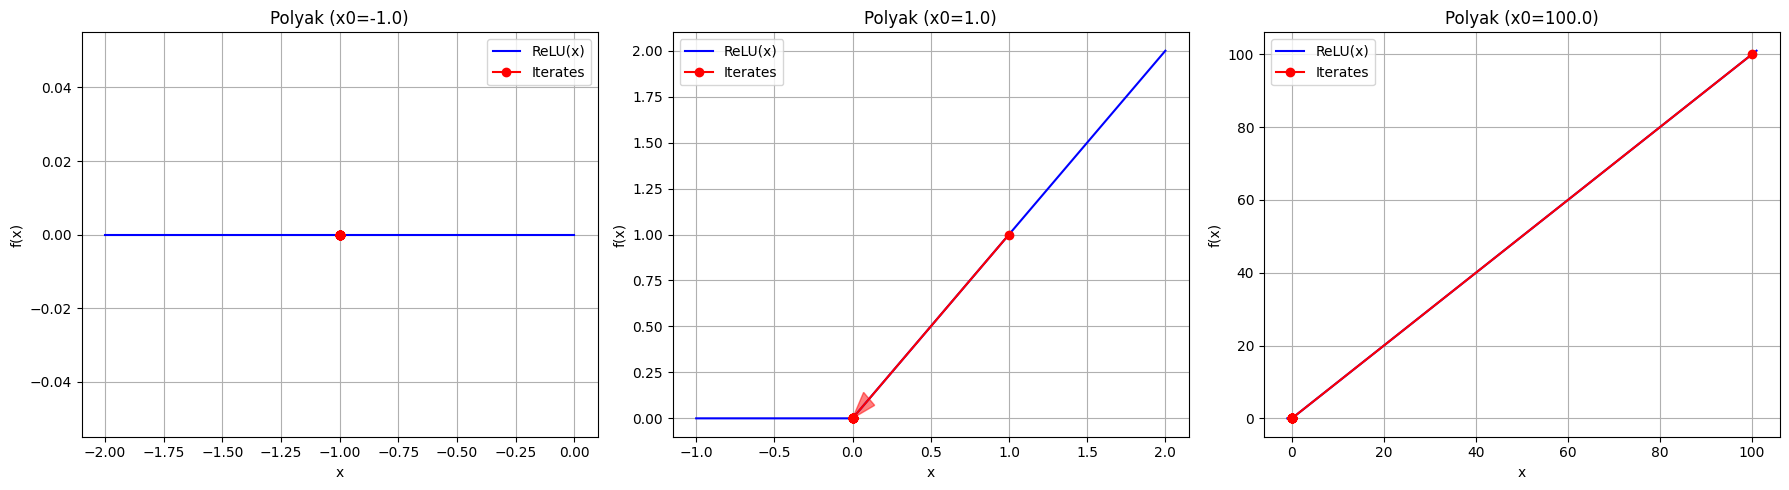

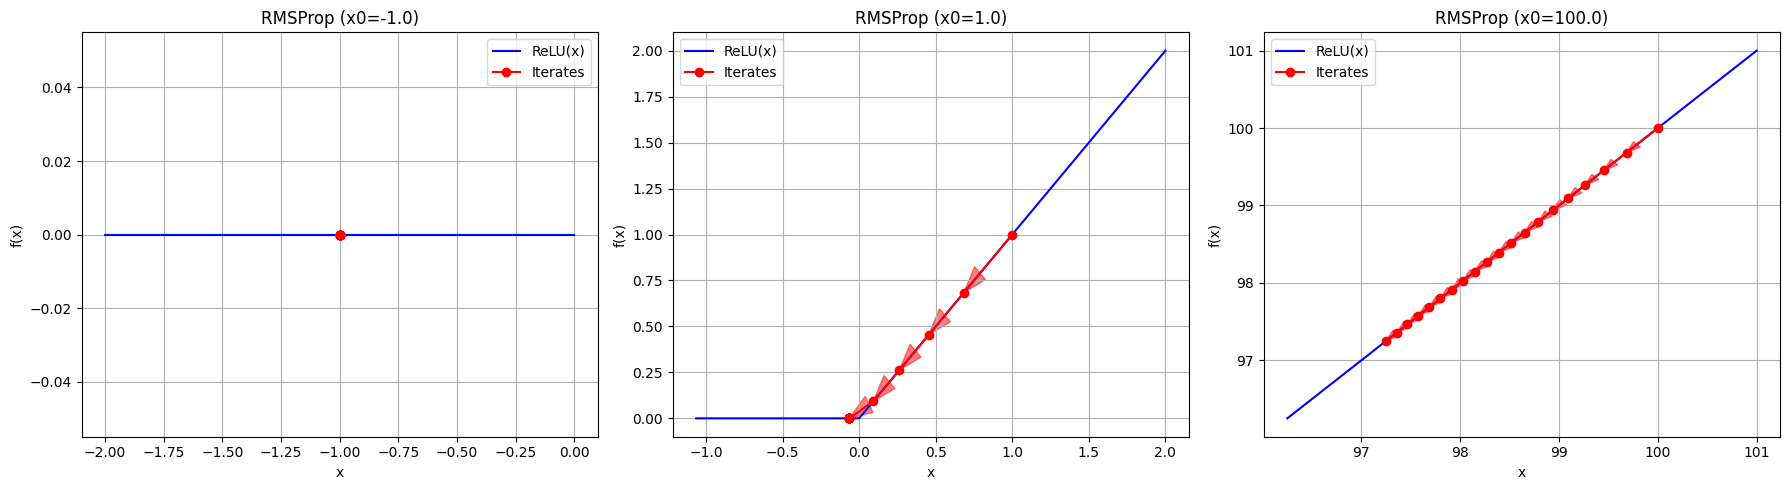

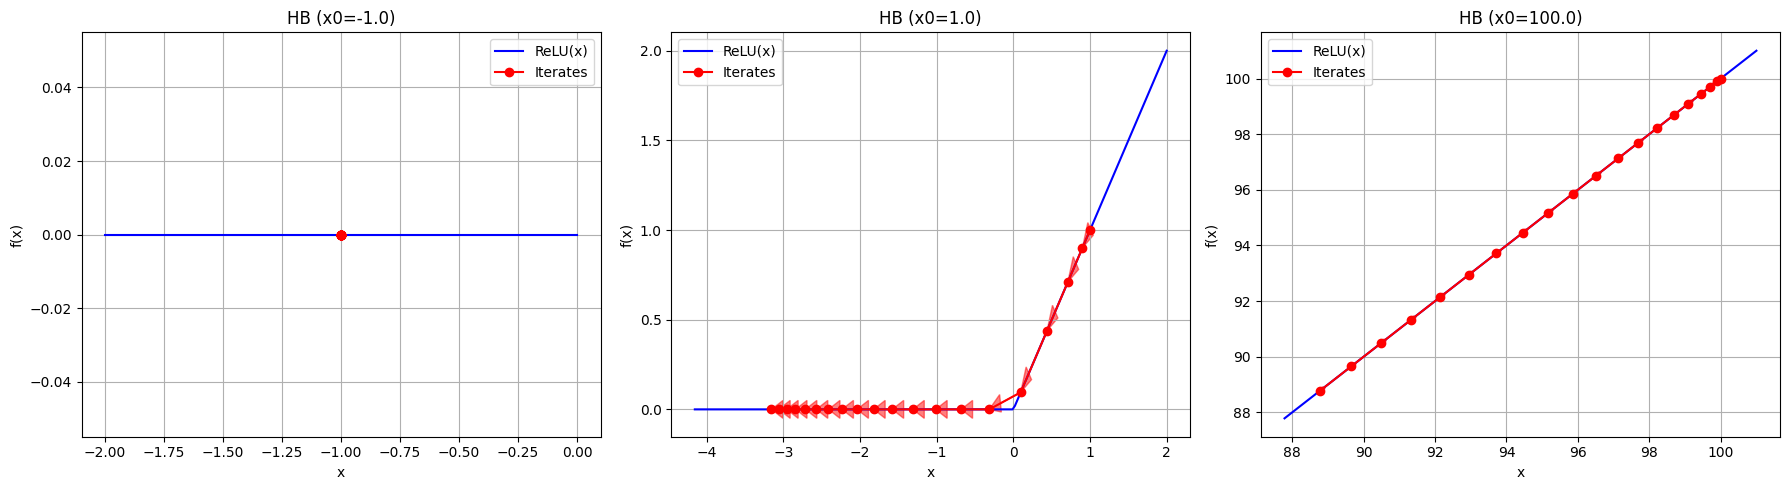

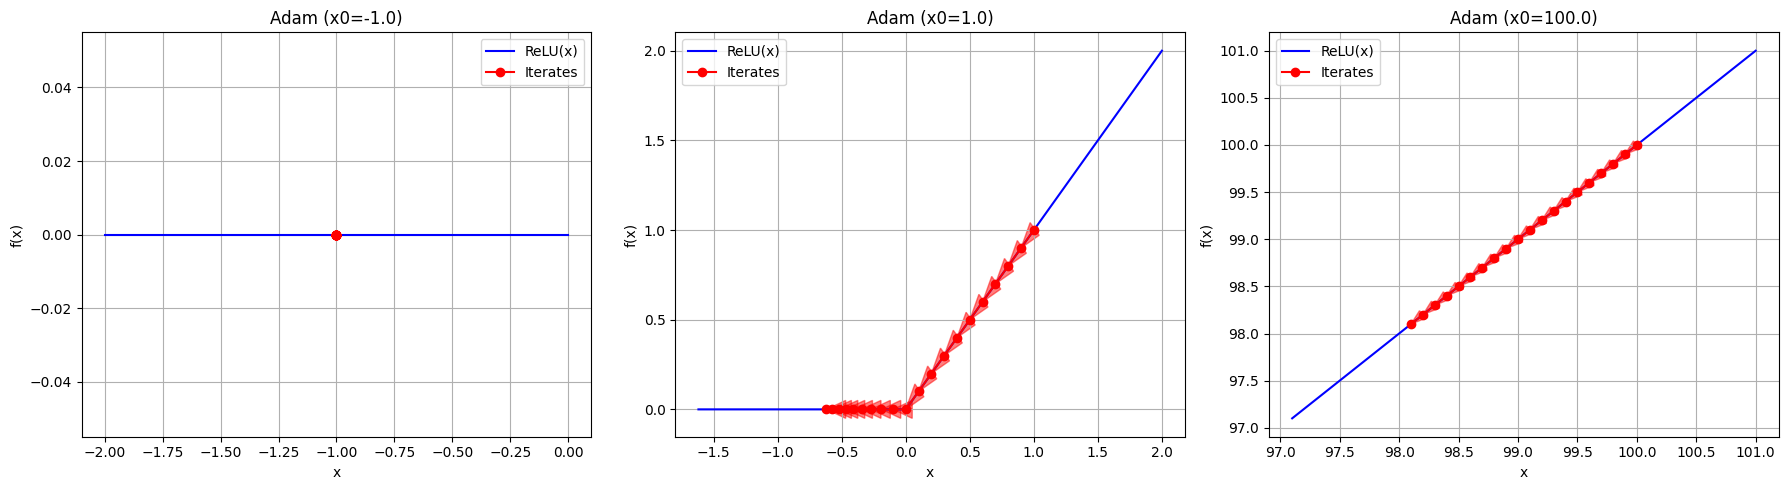

In [15]:
def plot_method_across_inits(results, method_name, inits, figsize=(18,5)):
    fig, axs = plt.subplots(1, len(inits), figsize=figsize)
    for i, x0 in enumerate(inits):
        hist = results[x0][method_name]
        plot_relu_path(hist, axs[i], 
                       title=f"{method_name} (x0={x0})", 
                       color="red")
    plt.tight_layout()
    plt.show()

plot_method_across_inits(results, "Polyak", inits)
plot_method_across_inits(results, "RMSProp", inits)
plot_method_across_inits(results, "HB", inits)
plot_method_across_inits(results, "Adam", inits)


### 5. Observations on the ReLU Plots

Below is a summary of how each method (Polyak, RMSProp, Heavy Ball, and Adam) behaves on the ReLU function $f(x) = \max(0, x)$ for different initial conditions $\{x_0 = -1, x_0 = +1, x_0 = +100\}$. The blue line is the ReLU function itself, and the red markers show the iteration points.

---

#### 1. $x_0 = -1$
For $x<0$, ReLU is flat with subgradient = $0$. Gradient-based methods have no signal to move, so they remain at their initial point.

---

#### 2. $x_0 = +1$
- **Polyak**: The algorithm makes a single or a few steps downward (depending on step-size logic), crossing zero. Once $x\le0$, the gradient becomes zero and the method stays there. 
- **RMSProp**: Iterations quickly move from $x=1$ down toward $0$. Once the iterate crosses or hits zero, the gradient is zero and no further updates happen. 
- **Heavy Ball**: Similar behavior: a sequence of descending steps until $x\le0$, then it remains in the flat region. 
- **Adam**: Also descends from $x=1$ to around $0$, at which point the gradient is zero.

**Why?**  
For $x>0$, ReLU is $f(x)=x$. Its gradient is $1$. Each method subtracts some step-size $\times 1$, driving $x$ downward. Once $x$ crosses 0, the subgradient is $0$, and the algorithm stops moving (the function is at its global minimum of $0$).

---

#### 3. $x_0 = +100$
- **Polyak**: Each update subtracts $\frac{(f(x) - f^*)}{\text{grad}^2}$. If $f^*=0$, the step size is roughly $\frac{(100 - 0)}{1^2}=100$ initially, so you might see a large jump in one step (if it doesn’t overshoot). After crossing zero, the gradient is zero, so it stays put.
- **RMSProp**: Gradually steps down from $100$ toward $0$. With $\alpha=0.1$, each iteration moves about $0.1$ if the cached gradient doesn’t grow too large. You can see many small steps before it eventually crosses zero.
- **Heavy Ball**: Moves in increments of $\beta \cdot v + \alpha \cdot \nabla f$. Because $\nabla f=1$ for $x>0$, the velocity accumulates. Depending on the parameters, it may take a few large steps or many smaller ones, but ultimately crosses zero and stays there.
- **Adam**: Similar to RMSProp, but with adaptive moment estimates. Each iteration subtracts $\alpha \times \frac{m}{\sqrt{v} + \epsilon}$. From $x=100$, it takes repeated steps until crossing $0$.

**Why?**  
Once $x>0$, the ReLU gradient is $1$, so each method effectively subtracts some fraction of $1$ from $x$. A large initial $\alpha$ or a Polyak step can quickly jump to or past zero; a smaller $\alpha$ requires many iterations to reduce $x$ from $100$ down to $0$.

---